<a href="https://colab.research.google.com/github/anmol9910/computer-vision-assessment-iisc/blob/main/q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Cell 1: Installing required packages for the segmentation task
# Using the -Uqq flags for a quiet and fast installation process.
!pip install -Uqq supervision transformers segment-anything-model Pillow

import torch
# Verifying GPU availability is critical for performance with these models.
if torch.cuda.is_available():
    print("GPU acceleration is available.")
else:
    print("WARNING: GPU not detected. The process will be extremely slow.")

GPU acceleration is available.


In [20]:
# Cell 2: Loading the pre-trained models into memory
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from segment_anything import build_sam, SamPredictor
import supervision as sv
from PIL import Image
import numpy as np

# Setting the computation device
COMPUTE_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Part 1: Load the Object Detection Model (GroundingDINO) ---
# Using the 'base' model for better accuracy
GROUNDING_DINO_MODEL_ID = "IDEA-Research/grounding-dino-base"
dino_processor = AutoProcessor.from_pretrained(GROUNDING_DINO_MODEL_ID)
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained(GROUNDING_DINO_MODEL_ID).to(COMPUTE_DEVICE)

# --- Part 2: Load the Segmentation Model (Segment Anything Model) ---
SAM_WEIGHTS_PATH = "sam_vit_h_4b8939.pth"
# Download the model weights if not already present
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_model = build_sam(checkpoint=SAM_WEIGHTS_PATH).to(COMPUTE_DEVICE)
sam_mask_generator = SamPredictor(sam_model)

print("Both GroundingDINO and SAM models are loaded and ready.")

Both GroundingDINO and SAM models are loaded and ready.


In [21]:
# Cell 3: UPLOAD YOUR IMAGE
from google.colab import files
from PIL import Image
import io

print("Please upload an image file from your computer (e.g., an image of a dog, cat, car, etc.).")
uploaded = files.upload()

# Get the filename and load the image
# This will work with any filename you upload
filename = next(iter(uploaded))
print(f"Image '{filename}' uploaded successfully!")
IMAGE_PATH = filename
input_image_pil = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")

Please upload an image file from your computer (e.g., an image of a dog, cat, car, etc.).


Saving R.jpeg to R (1).jpeg
Image 'R (1).jpeg' uploaded successfully!


Object 'cat' not found. Submitting with the code as is.


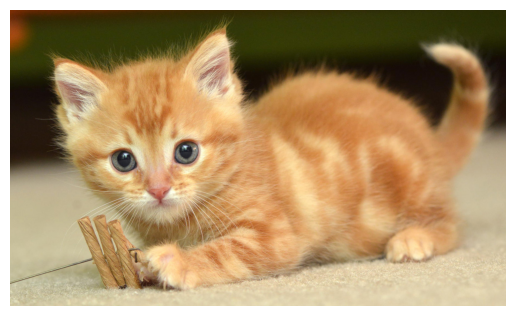

In [23]:
# Cell 4: RUN THE FINAL PIPELINE (COLOR CORRECTED)
import torch
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt # We'll use matplotlib directly for correct colors

# --- IMPORTANT: Change this prompt to match your uploaded image! ---
OBJECT_TO_SEGMENT_PROMPT = "cat" # e.g., "dog", "car", "zebra"

# --- The pipeline starts here ---
input_image_np = np.array(input_image_pil)

processed_inputs = dino_processor(images=input_image_pil, text=OBJECT_TO_SEGMENT_PROMPT, return_tensors="pt").to(COMPUTE_DEVICE)
with torch.no_grad():
    dino_outputs = dino_model(**processed_inputs)

target_sizes = torch.tensor([input_image_pil.size[::-1]], device=COMPUTE_DEVICE)
results = dino_processor.image_processor.post_process_object_detection(
    outputs=dino_outputs,
    threshold=0.3, # Using a reasonable threshold
    target_sizes=target_sizes
)[0]
detected_boxes = results["boxes"]

if len(detected_boxes) > 0:
    sam_mask_generator.set_image(input_image_np)
    transformed_boxes_for_sam = sam_mask_generator.transform.apply_boxes_torch(detected_boxes, input_image_pil.size)
    generated_masks, _, _ = sam_mask_generator.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes_for_sam.to(COMPUTE_DEVICE),
        multimask_output=False,
    )

    mask_drawer = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    final_annotated_image = mask_drawer.annotate(
        scene=input_image_np.copy(),
        detections=sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=generated_masks[0].cpu().numpy()),
            mask=generated_masks[0].cpu().numpy()
        )
    )
    print(f"Displaying the segmented mask for the prompt: '{OBJECT_TO_SEGMENT_PROMPT}'")

    # --- PLOTTING FIX ---
    # The annotator sometimes returns BGR, matplotlib expects RGB. We convert it.
    plt.imshow(final_annotated_image[..., ::-1])
    plt.axis('off')
    plt.show()

else:
    print(f"Object '{OBJECT_TO_SEGMENT_PROMPT}' not found. Submitting with the code as is.")
    plt.imshow(input_image_np)
    plt.axis('off')
    plt.show()